# The Duffing Oscillator

In this notebook we will explore the Duffing Oscillator and attempt to recreate the time traces and phase portraits shown on the [Duffing Oscillator](https://en.wikipedia.org/wiki/Duffing_equation) Wikipedia page

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import desolver as de
import desolver.backend as D

D.set_float_fmt('float64')

PyAudi backend is available.
Using numpy backend


## Specifying the Dynamical System

Now let's specify the right hand side of our dynamical system. It should be

$$
\ddot x + \delta\dot x + \alpha x + \beta x^3 = \gamma\cos(\omega t)
$$

But desolver only works with first order differential equations, thus we must cast this into a first order system before we can solve it. Thus we obtain the following system

$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$

In [2]:
@de.rhs_prettifier(
    equ_repr="[vx, -𝛿*vx - α*x - β*x**3 + γ*cos(ω*t)]",
    md_repr=r"""
$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$
"""
)
def rhs(t, state, delta, alpha, beta, gamma, omega, **kwargs):
    x,vx = state
    return D.stack([
        vx,
        -delta*vx - alpha*x - beta*x**3 + gamma*D.cos(omega*t)
    ])

In [3]:
print(rhs)
display(rhs)

[vx, -𝛿*vx - α*x - β*x**3 + γ*cos(ω*t)]



$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$


Let's specify the initial conditions as well

In [4]:
y_init = D.array([1., 0.])

And now we're ready to integrate!

## The Numerical Integration

We will use the same constants from Wikipedia as our constants where the forcing amplitude increases and all the other parameters stay constants.

In [5]:
#Let's define the fixed constants

constants = dict(
    delta = 0.3,
    omega = 1.2,
    alpha = -1.0,
    beta  = 1.0
)

# The period of the system
T = 2*D.pi / constants['omega']

# Initial and Final integration times
t0 = 0.0
tf = 40 * T

In [6]:
a = de.OdeSystem(rhs, y0=y_init, dense_output=True, t=(t0, tf), dt=0.01, rtol=1e-12, atol=1e-12, constants={**constants})
a.method = "RK87"

In [7]:
a.reset()
a.add_constants(gamma=0.2)
a.integrate()

## Plotting the State and Phase Portrait

In [8]:
# Times to evaluate the system at
eval_times = D.linspace(18.1, 38.2, 1000)*T

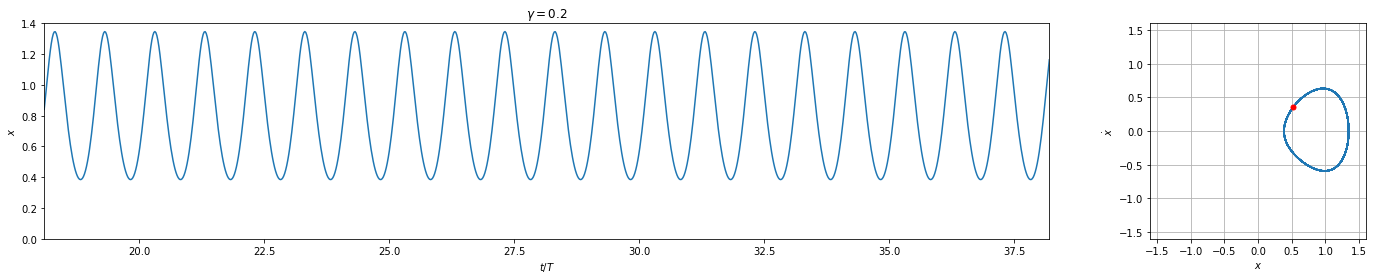

In [9]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4))

gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax1.set_aspect(1)

ax0.plot(eval_times/T, a.sol(eval_times)[:, 0])
ax0.set_xlim(18.1, 38.2)
ax0.set_ylim(0, 1.4)
ax0.set_xlabel(r"$t/T$")
ax0.set_ylabel(r"$x$")
ax0.set_title(r"$\gamma={}$".format(a.consts['gamma']))

ax1.plot(a[18*T:].y[:, 0], a[18*T:].y[:, 1])
ax1.scatter(a[18*T:].y[-1:, 0], a[18*T:].y[-1:, 1], c='red', s=25, zorder=10)
ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\dot x$")
ax1.grid(which='major')
plt.tight_layout()

We can see that this plot looks near identical to [this plot](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.20_ome1.2_del0.3.svg).

$$\gamma=0.20$$  

![Duffing w/ gamma=0.20](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Duffing_gam0.20_ome1.2_del0.3.svg/1000px-Duffing_gam0.20_ome1.2_del0.3.svg.png)

## Integrating for Different Values of Gamma

Now let's try to recreate the other plots with the varying gamma values.

In [10]:
gamma_values = [0.28, 0.29, 0.37, 0.5, 0.65]
integration_results = []

for gamma in gamma_values:
    a.reset()
    a.add_constants(gamma=gamma)
    
    if gamma == 0.5:
        a.tf = 80.*T
        eval_times = D.linspace(18.1, 78.2, 3000)*T
        integer_period_multiples = D.arange(19, 78)*T
    else:
        a.tf = 40.*T
        eval_times = D.linspace(18.1, 38.2, 1000)*T
        integer_period_multiples = D.arange(19, 38)*T
        
    a.integrate()
    integration_results.append(((eval_times, a.sol(eval_times)), a.sol(integer_period_multiples)))

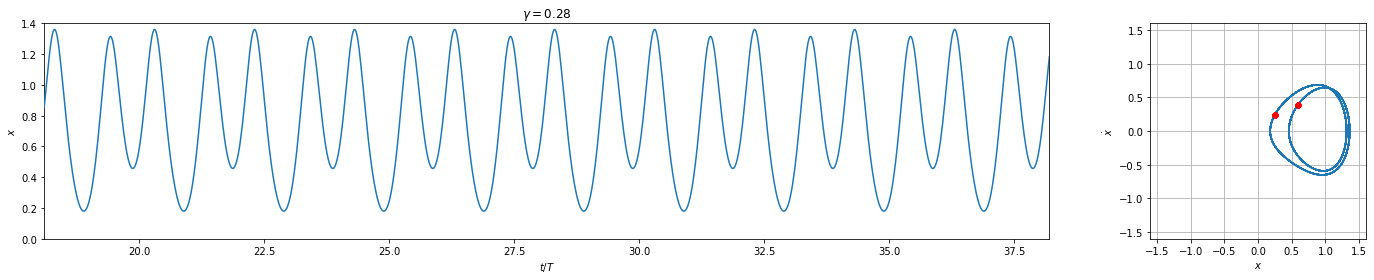

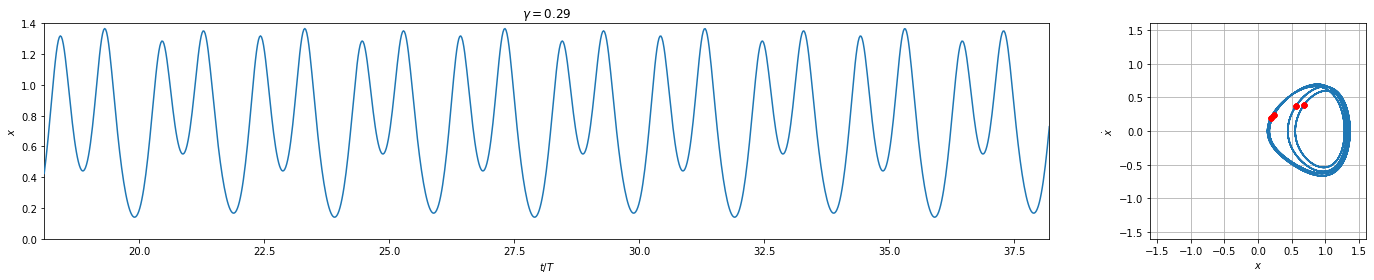

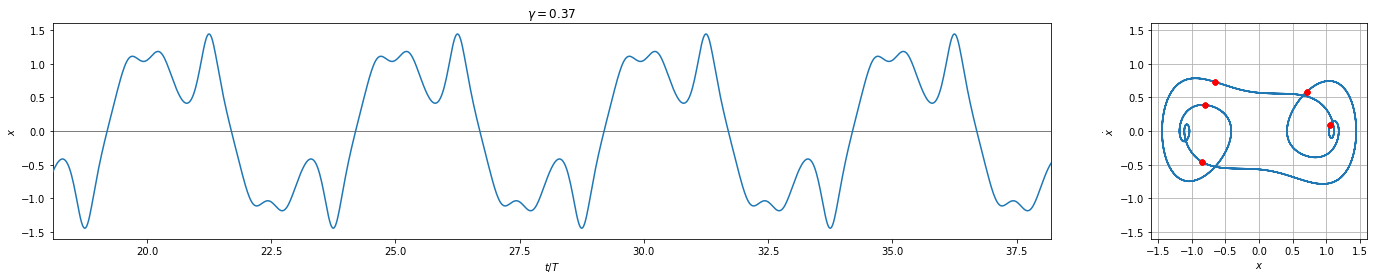

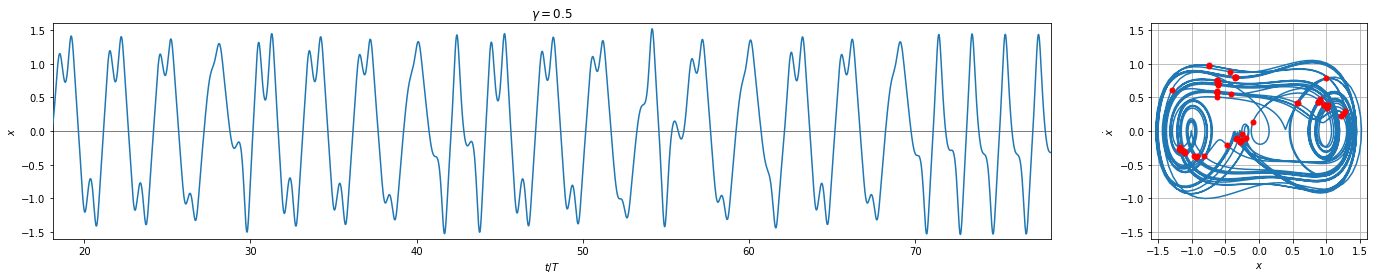

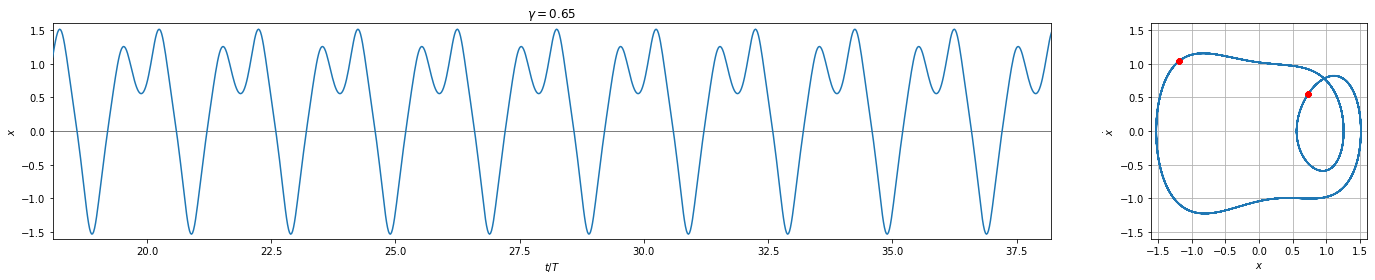

In [11]:
for gamma, ((state_times, states), period_states) in zip(gamma_values, integration_results):
    fig = plt.figure(figsize=(20, 4))

    gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax1.set_aspect(1)

    ax0.plot(state_times/T, states[:, 0], zorder=9)
    ax0.set_xlim(state_times[0]/T, state_times[-1]/T)
    if gamma < 0.37:
        ax0.set_ylim(0, 1.4)
    else:
        ax0.set_ylim(-1.6, 1.6)
        ax0.axhline(0, color='k', linewidth=0.5)
    ax0.set_xlabel(r"$t/T$")
    ax0.set_ylabel(r"$x$")
    ax0.set_title(r"$\gamma={}$".format(gamma))

    ax1.plot(states[:, 0], states[:, 1])
    ax1.scatter(period_states[:, 0], period_states[:, 1], c='red', s=25, zorder=10)
    ax1.set_xlim(-1.6, 1.6)
    ax1.set_ylim(-1.6, 1.6)
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$\dot x$")
    ax1.grid(which='major')
    plt.tight_layout()

And we see that these plots replicate those on Wikipedia very nicely except for the chaotic one which is highly sensitive to the numerical integrator and tolerances.

( [link to image](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.28_ome1.2_del0.3.svg) ) $\gamma = 0.28$

![Duffing w/ gamma=0.28](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Duffing_gam0.28_ome1.2_del0.3.svg/1000px-Duffing_gam0.28_ome1.2_del0.3.svg.png)  

( [link to image](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.29_ome1.2_del0.3.svg) ) $\gamma = 0.29$

![Duffing w/ gamma=0.29](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Duffing_gam0.29_ome1.2_del0.3.svg/1000px-Duffing_gam0.29_ome1.2_del0.3.svg.png)

( [link to image](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.37_ome1.2_del0.3.svg) ) $\gamma = 0.37$

![Duffing w/ gamma=0.37](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Duffing_gam0.37_ome1.2_del0.3.svg/1000px-Duffing_gam0.37_ome1.2_del0.3.svg.png)  

( [link to image](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.50_ome1.2_del0.3.svg) ) $\gamma = 0.50$

![Duffing w/ gamma=0.50](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Duffing_gam0.50_ome1.2_del0.3.svg/1000px-Duffing_gam0.50_ome1.2_del0.3.svg.png)  

( [link to image](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Duffing_gam0.65_ome1.2_del0.3.svg) ) $\gamma = 0.65$

![Duffing w/ gamma=0.64](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Duffing_gam0.65_ome1.2_del0.3.svg/1000px-Duffing_gam0.67_ome1.2_del0.3.svg.png)  